In [1]:
%pip install cleverhans;

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import AveragePooling2D, Conv2D
import matplotlib.pyplot as plt
import pandas as pd


from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

FLAGS = flags.FLAGS

2022-11-25 13:00:07.469481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/karendamata/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CNN(Model):
    def __init__(self, nb_filters=64):
        super(CNN, self).__init__()
        img_size = 32
        log_resolution = int(round(math.log(img_size) / math.log(2)))
        conv_args = dict(activation=tf.nn.leaky_relu, kernel_size=3, padding="same")
        self.layers_obj = []
        for scale in range(log_resolution - 2):
            conv1 = Conv2D(nb_filters << scale, **conv_args)
            conv2 = Conv2D(nb_filters << (scale + 1), **conv_args)
            pool = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))
            self.layers_obj.append(conv1)
            self.layers_obj.append(conv2)
            self.layers_obj.append(pool)
        conv = Conv2D(10, **conv_args)
        self.layers_obj.append(conv)

    def call(self, x):
        for layer in self.layers_obj:
            x = layer(x)
        return tf.reduce_mean(x, [1, 2])

In [4]:
def ld_cifar10():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 127.5
        image -= 1.0
        return image, label

    dataset, info = tfds.load("cifar10", with_info=True, as_supervised=True)

    def augment_mirror(x):
        return tf.image.random_flip_left_right(x)

    def augment_shift(x, w=4):
        y = tf.pad(x, [[w] * 2, [w] * 2, [0] * 2], mode="REFLECT")
        return tf.image.random_crop(y, tf.shape(x))

    cifar10_train, cifar10_test = dataset["train"], dataset["test"]
    # Augmentation helps a lot in CIFAR10
    cifar10_train = cifar10_train.map(
        lambda x, y: (augment_mirror(augment_shift(x)), y)
    )
    cifar10_train = cifar10_train.map(convert_types).shuffle(10000).batch(128)
    cifar10_test = cifar10_test.map(convert_types).batch(128)

    return EasyDict(train=cifar10_train, test=cifar10_test, info=info)

In [5]:
def img_plt(x_data, img_number=None):
    if img_number == None:
        item = np.array(x_data)
    else:
        item = np.array(x_data.__getitem__(img_number))
    min = abs(item.min())
    max = abs(item.max())

    np.array(item)
    plt.imshow(((item+min)*(127 + (1-max)))/255);


# Loading the Data

In [6]:
data = ld_cifar10()
model = CNN()
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# Metrics to track the different accuracies.
train_loss = tf.metrics.Mean(name="train_loss")
test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()
test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()
test_acc_poissoned = tf.metrics.SparseCategoricalAccuracy()
   

2022-11-25 13:00:39.178343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [512]:
classes = {'0': 'airplane', '1': 'automobile', '2': 'bird', '3': 'cat', '4': 'deer', '5': 'dog', '6': 'frog', '7': 'horse', '8': 'ship', '9': 'truck'}
classes

{'0': 'airplane',
 '1': 'automobile',
 '2': 'bird',
 '3': 'cat',
 '4': 'deer',
 '5': 'dog',
 '6': 'frog',
 '7': 'horse',
 '8': 'ship',
 '9': 'truck'}

# Training the Classifier

In [7]:
nb_epochs = 1;
eps = 0.05;
adv_train = False;

In [8]:

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    predictions = model(x)
    # predictions = tf.keras.activations.softmax(predictions)
    loss = loss_object(y, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)

for epoch in range(nb_epochs):
  progress_bar_train = tf.keras.utils.Progbar(50000)
  for (x, y) in data.train:
    if adv_train:
      # Replace clean example with adversarial example for adversarial training
      x = projected_gradient_descent(model, x, eps, 0.01, 40, np.inf)
    train_step(x, y)
    progress_bar_train.add(x.shape[0], values=[("loss", train_loss.result())])

50000/50000 [==============================] - 1179s 24ms/step - loss: 1.8679


In [9]:
! mkdir -p saved_model
model.save('saved_model/my_model')

new_model = tf.keras.models.load_model('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [11]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Creating the Adversarial Examples
10000 of each attack.

In [15]:
progress_bar_test = tf.keras.utils.Progbar(10000)
real_x = tf.zeros([0, 32, 32, 3], dtype=float)
real_y = tf.zeros([0], dtype='int64')
real_label = tf.convert_to_tensor(np.array([0]*10000), dtype='int32')

X_fgm = tf.zeros([0, 32, 32, 3], dtype=float)
Y_fgm = tf.zeros([0], dtype='int64')
fgm_label = tf.convert_to_tensor(np.array([1]*10000), dtype='int32')

X_pgd = tf.zeros([0, 32, 32, 3], dtype=float)
Y_pgd= tf.zeros([0], dtype='int64')
pgd_label = tf.convert_to_tensor(np.array([2]*10000), dtype='int32')

for x, y in data.test:
  x_fgm = fast_gradient_method(model, x, eps, np.inf)
  X_fgm = tf.concat([X_fgm, x_fgm], 0)
  Y_fgm = tf.concat([Y_fgm, y], 0)

  # x_pgd = projected_gradient_descent(model, x, eps, 0.01, 40, np.inf)
  # X_pgd = tf.concat([X_pgd, x_fgm], 0)
  # Y_pgd = tf.concat([Y_pgd, y], 0)

  real_x = tf.concat([real_x, x], 0)
  real_y = tf.concat([real_y, y], 0)
  progress_bar_test.add(x.shape[0])

10000/10000 [==============================] - 210s 21ms/step


In [17]:
# Adding a real label data
real_df = tf.data.Dataset.from_tensor_slices((real_x, real_y, real_label)).take(6000)
fgm_df = tf.data.Dataset.from_tensor_slices((X_fgm, Y_fgm, fgm_label)).take(4000)
# pgd_df = tf.data.Dataset.from_tensor_slices((X_pgd, Y_pgd, pgd_label)).take(2000)
real_fake = real_df.concatenate(fgm_df)
# real_pgd = real_df.concatenate(pgd_df)
# real_fake = real_fgm.concatenate(pgd_df)

In [19]:
# Shuffling the combined data
shuffled = real_fake.shuffle(10000)
shuffled = shuffled.batch(batch_size=128)
combined_test = shuffled.take(79)
image, Class, label = tuple(zip(*combined_test))

In [20]:
acc = np.array([])
predictions_real = np.array([])
progress_bar_test = tf.keras.utils.Progbar(10000)
for (x, y) in data.test:
  y_pred = model(x)
  predictions_real = np.append(predictions_real, [ np.argmax(item) for item in y_pred.numpy()])
  test_acc_clean(y, y_pred)
  acc = np.append(acc, test_acc_clean.result().numpy())
  progress_bar_test.add(x.shape[0])
print(f"Accuracy using Real Examples: {acc.mean()*100}%")

10000/10000 [==============================] - 57s 6ms/step
Accuracy using Real Examples: 57.12353172181528%


In [21]:
acc_poissoned = np.array([])
predictions = np.array([])
progress_bar_test = tf.keras.utils.Progbar(10000)
for x,y,z in combined_test:
    y_pred = model(x)
    # y_pred = tf.keras.activations.softmax(y_pred)
    predictions = np.append(predictions, [ np.argmax(item) for item in y_pred.numpy()])
    # test_acc_poissoned.reset_state()
    test_acc_poissoned(y, y_pred)
    acc_poissoned = np.append(acc_poissoned, test_acc_poissoned.result().numpy())
    progress_bar_test.add(x.shape[0])
print(f"Accuracy using Fake Examples: {acc_poissoned.mean()*100}%")

10000/10000 [==============================] - 59s 6ms/step
Accuracy using Fake Examples: 43.79313150538674%


In [22]:
image, Class, label = tuple(zip(*combined_test.unbatch()))

In [28]:
results = pd.DataFrame([predictions, np.array(Class), np.array(label)], index=['Predictions', 'Expected Y', '0 - Real, 1 - FGM, 2 - PGD']).T

In [29]:
results

,Predictions,Expected Y,"0 - Real, 1 - FGM, 2 - PGD"
0,8.0,6.0,0.0
1,2.0,7.0,1.0
2,6.0,8.0,0.0
3,9.0,8.0,1.0
4,8.0,7.0,0.0
...,...,...,...
9995,7.0,0.0,0.0
9996,2.0,2.0,1.0
9997,8.0,0.0,0.0
9998,7.0,8.0,0.0


In [30]:
results['Comparisson'] = list(int(item) for item in (results['Predictions'] == results['Expected Y']))

In [31]:
results

,Predictions,Expected Y,"0 - Real, 1 - FGM, 2 - PGD",Comparisson
0,8.0,6.0,0.0,0
1,2.0,7.0,1.0,0
2,6.0,8.0,0.0,0
3,9.0,8.0,1.0,0
4,8.0,7.0,0.0,0
...,...,...,...,...
9995,7.0,0.0,0.0,0
9996,2.0,2.0,1.0,1
9997,8.0,0.0,0.0,0
9998,7.0,8.0,0.0,0


In [32]:
results.groupby(['0 - Real, 1 - FGM, 2 - PGD', 'Comparisson']).count()

Predictions  Expected Y
0 - Real, 1 - FGM, 2 - PGD Comparisson                         
0.0                        0                   5408        5408
                           1                    592         592
1.0                        0                   3617        3617
                           1                    383         383

# Creating Failure Times Array

In [34]:
faults = np.array([])
for row in range(len(results)):
    if results['0 - Real, 1 - FGM, 2 - PGD'][row] == 0:
        faults = np.append(faults, 0)
    else:
        if results['Comparisson'][row] == 1:
            faults = np.append(faults, 1)
        else:
            faults = np.append(faults, 0)

In [35]:
results['prediction_results'] = faults

In [36]:
results

,Predictions,Expected Y,"0 - Real, 1 - FGM, 2 - PGD",Comparisson,prediction_results
0,8.0,6.0,0.0,0,0.0
1,2.0,7.0,1.0,0,0.0
2,6.0,8.0,0.0,0,0.0
3,9.0,8.0,1.0,0,0.0
4,8.0,7.0,0.0,0,0.0
...,...,...,...,...,...
9995,7.0,0.0,0.0,0,0.0
9996,2.0,2.0,1.0,1,1.0
9997,8.0,0.0,0.0,0,0.0
9998,7.0,8.0,0.0,0,0.0


In [56]:
n_failures = sum(results['prediction_results'])
fn = np.linspace(1,n_failures, num=int(n_failures))
ft = np.where(results['prediction_results']==1)


In [76]:
d = {"Failure Number" : fn , "Failure Time": ft[0]}
ft_df = pd.DataFrame(data = d)
ft_df.set_index('Failure Number')

,Failure Time
Failure Number,
1.0,18
2.0,27
3.0,95
4.0,105
5.0,142
...,...
379.0,9919
380.0,9923
381.0,9942


In [94]:
tbf = [ft[0][index]-ft[0][index-1] for index in range(1, len(ft[0])-1)]
np.array(tbf)

array([  9,  68,  10,  37,   5,   4,   9,   4,  19,  15,  12,  33,  16,
       135,  12,  75,  21,   4,  16,   4,  31,  56,   9,  19,  36,  21,
        25,  38,   3,  56,  32, 115,   5,   4,  18,   3,   8,   1,   6,
        10,   2,  30,   4,   5,  20,  19,  68,  43,  21,   5,   8,  16,
        58,  14,  10,  17,   4,  41,   3,   4,   7,  45,   8,  47,  12,
         4,  10,  59,  18,  48,  50,   6,  26,  11,  45,   1,   4,  12,
        17,   1,   2,  71,   3,  87,   1, 120,  19,   1,   1,  36,  40,
         7,  19,   1,  38,  27,  30,  15,   1,  42,  35,  26,   6,  19,
        33,  24,  23,  24,  37,  13,  48,  70,  20,  44,  94,  82,  34,
         1,  19,  18,  12,  39,   6,   1,  27,  40,  16,  26,  37,  16,
        58,  39,  24,  30,   2,  15,  16,  13,   9,  10,  53,  11,  20,
         2,   6,  19,  16,  14,  54,  47,  47,  10,   4,   9,  11,  25,
        10,  57,  53,   6,  41,   2,   4,   7,  56,   3,  13,  25,   3,
        24,  58,  28,  55,  30,  93,  23,  21,   4,  62,   2,   

In [81]:
ft_df.to_csv('ft_df.csv')

In [82]:
fc_df.to_csv('fc_df.csv')

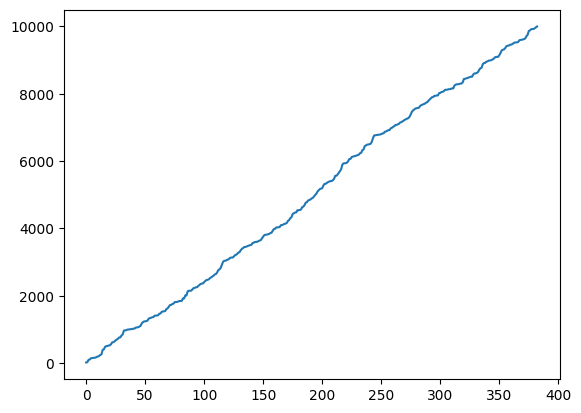

In [77]:
plt.plot(ft_df['Failure Time']);

# Creating Failure Count Array
Considering 50 images as time step

In [73]:
failure_counts = np.array([])
failure_splits = np.split(faults, (len(faults)/50))
for i in range(len(failure_splits)):
    failure_counts = np.append(failure_counts, sum(failure_splits[i]))
failure_counts

array([2., 1., 3., 5., 2., 1., 0., 1., 1., 1., 4., 1., 3., 2., 1., 2., 1.,
       1., 0., 5., 5., 4., 1., 1., 4., 1., 3., 2., 4., 2., 4., 0., 2., 1.,
       2., 2., 7., 0., 2., 0., 2., 0., 3., 2., 2., 3., 2., 2., 2., 3., 2.,
       2., 2., 1., 0., 2., 1., 0., 1., 0., 3., 3., 3., 1., 3., 2., 0., 2.,
       3., 3., 2., 4., 3., 1., 1., 1., 5., 2., 1., 2., 4., 2., 3., 1., 1.,
       1., 2., 0., 1., 3., 3., 1., 2., 1., 0., 2., 2., 2., 2., 1., 1., 1.,
       1., 3., 0., 1., 2., 3., 3., 1., 0., 3., 1., 1., 0., 1., 0., 1., 3.,
       2., 0., 2., 3., 4., 2., 0., 2., 0., 1., 3., 2., 1., 0., 1., 0., 6.,
       3., 2., 3., 2., 2., 3., 2., 3., 2., 2., 1., 1., 0., 1., 2., 4., 1.,
       3., 3., 1., 1., 3., 3., 1., 3., 2., 6., 2., 1., 4., 3., 0., 2., 4.,
       2., 1., 4., 0., 1., 2., 0., 1., 3., 4., 2., 4., 1., 0., 1., 1., 2.,
       1., 3., 4., 4., 2., 4., 0., 2., 0., 0., 2., 4., 2.])

<AxesSubplot:ylabel='Density'>

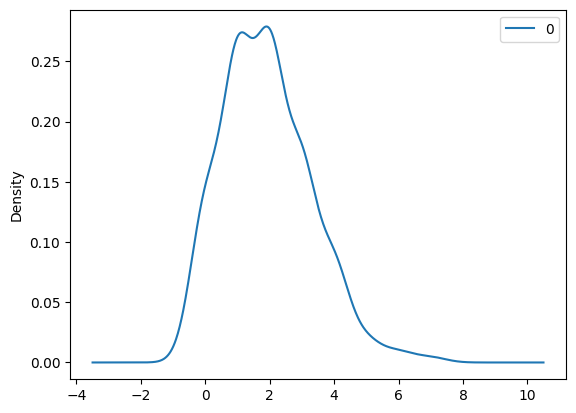

In [78]:
fc_df = pd.DataFrame(failure_counts)
fc_df.plot(kind='density')

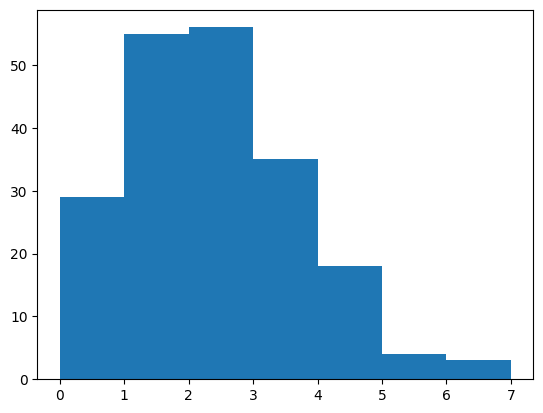

In [79]:
plt.hist(failure_counts, bins = 7);